In [1]:
import time
from pprint import pprint
# from math import round
from multiprocessing import Pool

from IPython.display import display

from pylab import *
isShow = True

In [2]:
def g(t, eps):
    return (-exp(t/eps) + exp(t*(eps + 2)))*\
        exp(-eps*t + eps - t + 1 - t/eps + 1/eps)/\
        (-exp(1/eps) + exp(eps + 2))

def g1(t, eps):
    return exp(1.)*(eps**2 + 2.*eps - 1.)*exp(1./eps)*\
           exp(eps)/(eps*(-exp(1./eps) + exp(2.)*exp(eps)))

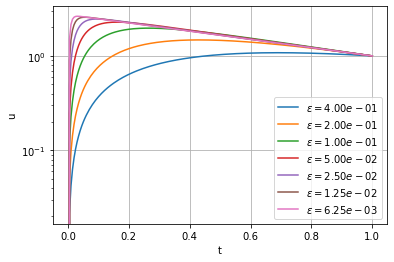

In [3]:
t = linspace(0., 1., 200)
# figure(figsize=(9, 6))
for eps in [0.4, 0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625]:
    plot(t, g(t, eps), label=r"$\varepsilon=%.2e$" % eps)
grid()
yscale("log")
legend(loc='best', fancybox=True)
xlabel('t')
ylabel('u')
show() if isShow else savefig('figRKFDA1.pdf')
close()

In [4]:
def GaussLegendre2(f, args, y, h):
    y1 = y.copy()
    for i in range(10):
        k1 = f(y1/2 + y/2, args)
        y1 = y + h*k1
    return k1

def CrankNicolson2(f, args, y, h):
    y1 = y.copy()
    for i in range(10):
        k1 = f(y, args)
        k2 = f(y1, args)
        y1 = y + h*(k1 + k2)/2
    return (k1 + k2)/2

def RK4(f, args, y, h):
    k1 = f(y, args)
    k2 = f(y + h/2*k1, args)
    k3 = f(y + h/2*k2, args)
    k4 = f(y + h*k3, args)
    return (k1 + 2*k2 + 2*k3 + k4)/6

def DormandPrince5(f, args, y, h):
    k1 = f(y, args)
    k2 = f(y + h*k1/5, args)
    k3 = f(y + h*(k1*3/40 + k2*9/40), args)
    k4 = f(y + h*(k1*44/45 - k2*56/15 + k3*32/9), args)
    k5 = f(y + h*(k1*19372/6561 - k2*25360/2187 + k3*64448/6561 - k4*212/729), args)
    k6 = f(y + h*(k1*9017/3168 - k2*355/33 + k3*46732/5247 + k4*49/176 - k5*5103/18656), args)
    return k1*35/384 + k3*500/1113 + k4*125/192 - k5*2187/6784 + k6*11/84

In [5]:
def Jacobi(y, args):
    k = args[0]
    return array([\
        y[1]*y[2],\
       -y[0]*y[2],\
       -k**2*y[0]*y[1],\
    ], dtype=float64)

def Duffing(y, args):
    eps = args[0]
    return array([\
        y[1],\
        -y[0] - eps*y[0]**3,\
    ], dtype=float64)

def BoundaryLayer(y, args):
    eps = args[0]
    return array([\
        y[1],\
        -((1 + eps**2)*y[1] + (1 - eps**2)*y[0])/eps,\
    ], dtype=float64)

def Test(y, args):
    l, a = args
    return array([\
        -l*(y[0]**2 - a**2),\
    ], dtype=float64)

## Jacobi

In [6]:
xk, n = 250., 7
res = empty((n, 5), dtype=float64)
for i in range(n):
    h = 1.0/2**i
    y = empty(3, dtype=float64)
    k = 0.5
    x, y[:], r0, r1, r2, r3 = 0., (1., 1., 1.), 0., 0., 0., 0.
    while x < xk:
        x += h
        y = y + h*RK4(Jacobi, [k], y, h)
        r0 = max(r0, abs(y[0]**2 + y[1]**2 - 2.0)/2.0)
        r1 = max(r1, abs(k**2*y[0]**2 + y[2]**2 - 1.25)/1.25)
        r2 = h**4*max(r2, abs(k**4*(y[0]**5*y[1]*y[2]/24 - y[0]*y[1]**5*y[2]/24)))
        r3 = h**4*max(r3, abs(k**2*(k*y[0] - y[2])*(k*y[0] + y[2])*(k**2*y[0]**2 + y[2]**2)*y[0]*y[1]*y[2]/24))
#     print(" & ".join((f"{h:<10}", f"{r0:<12.1e}", f"{r2:<12.1e}", f"{r1:<12.1e}", f"{r3:<12.1e}")), r"\\ \hline")
    res[i] = h, r0, r2, r1, r3

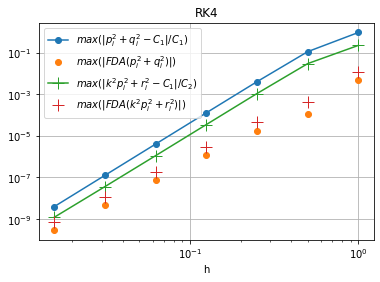

In [7]:
# figure(figsize=(9, 6))
title('RK4')
plot(res[:, 0], res[:, 1], marker='o', label=r"$max(\left|p_i^2  + q_i^2 - C_1\right|/C_1)$")
plot(res[:, 0], res[:, 2], 'o', label=r"$max(\left|FDA(p_i^2  + q_i^2)\right|)$")
plot(res[:, 0], res[:, 3], marker='+', markersize=12, label=r"$max(\left|k^2p_i^2  + r_i^2 - C_1\right|/C_2)$")
plot(res[:, 0], res[:, 4], '+', markersize=12, label=r"$max(\left|FDA(k^2p_i^2  + r_i^2)\right|)$")
grid()
yscale("log")
xscale("log")
legend(loc='best', fancybox=True)
xlabel('h')
# ylabel('u')
show() if isShow else savefig('figRKFDA2.pdf')
close()

In [8]:
xk, n = 250., 7
res = empty((n, 5), dtype=float64)
for i in range(n):
    h = 1.0/2**i
    y = empty(3, dtype=float64)
    k = 0.5
    x, y[:], r0, r1, r2, r3 = 0., (1., 1., 1.), 0., 0., 0., 0.
    while x < xk:
        x += h
        y = y + h*DormandPrince5(Jacobi, [k], y, h)
        r0 = max(r0, abs(y[0]**2 + y[1]**2 - 2.0)/2.0)
        r1 = max(r1, abs(k**2*y[0]**2 + y[2]**2 - 1.25)/1.25)
        r2 = h**5*max(r2, abs(k**6*(y[0]**6*y[1]**2/1800 - y[0]**2*y[1]**6/1800) +\
    k**4*(-13*y[0]**4*y[1]**2*y[2]**2/8100 - 13*y[0]**2*y[1]**4*y[2]**2/8100) +\
    k**2*(7*y[0]**4*y[2]**4/10800 - 7*y[1]**4*y[2]**4/10800) -\
    y[0]**2*y[2]**6/1800 - y[1]**2*y[2]**6/1800))
        r3 = h**5*max(r3, abs(k**8*(7*y[0]**4*y[1]**4/10800 - y[0]**2*y[1]**6/1800) +\
    k**6*(y[0]**6*y[2]**2/1800 - 13*y[0]**4*y[1]**2*y[2]**2/8100 -\
    y[1]**6*y[2]**2/1800) + k**4*(-13*y[0]**2*y[1]**2*y[2]**4/8100 -\
    7*y[1]**4*y[2]**4/10800) - k**2*y[0]**2*y[2]**6/1800))
#     print(" & ".join((f"{h:<10}", f"{r0:<12.1e}", f"{r2:<12.1e}", f"{r1:<12.1e}", f"{r3:<12.1e}")), r"\\ \hline")
    res[i] = h, r0, r2, r1, r3

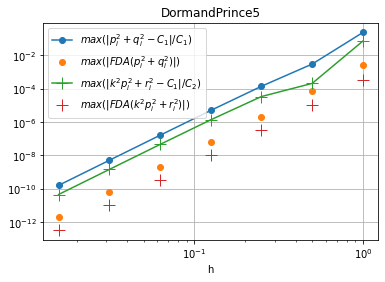

In [9]:
# figure(figsize=(9, 6))
title('DormandPrince5')
plot(res[:, 0], res[:, 1], marker='o', label=r"$max(\left|p_i^2  + q_i^2 - C_1\right|/C_1)$")
plot(res[:, 0], res[:, 2], 'o', label=r"$max(\left|FDA(p_i^2  + q_i^2)\right|)$")
plot(res[:, 0], res[:, 3], marker='+', markersize=12, label=r"$max(\left|k^2p_i^2  + r_i^2 - C_1\right|/C_2)$")
plot(res[:, 0], res[:, 4], '+', markersize=12, label=r"$max(\left|FDA(k^2p_i^2  + r_i^2)\right|)$")
grid()
yscale("log")
xscale("log")
legend(loc='best', fancybox=True)
xlabel('h')
# ylabel('u')
show() if isShow else savefig('figRKFDA3.pdf')
close()

In [10]:
xk, n = 250., 7
res = empty((n, 5), dtype=float64)
for i in range(n):
    h = 1.0/2**i
    y = empty(3, dtype=float64)
    k = 0.5
    x, y[:], r0, r1, r2, r3 = 0., (1., 1., 1.), 0., 0., 0., 0.
    while x < xk:
        x += h
        y = y + h*GaussLegendre2(Jacobi, [k], y, h)
        r0 = max(r0, abs(y[0]**2 + y[1]**2 - 2.0)/2.0)
        r1 = max(r1, abs(k**2*y[0]**2 + y[2]**2 - 1.25)/1.25)
        r2 = 1e-16
        r3 = 1e-16
#     print(" & ".join((f"{h:<10}", f"{r0:<12.1e}", f"{r2:<12.1e}", f"{r1:<12.1e}", f"{r3:<12.1e}")), r"\\ \hline")
    res[i] = h, r0, r2, r1, r3

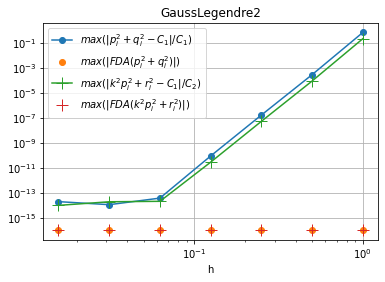

In [11]:
# figure(figsize=(9, 6))
title('GaussLegendre2')
plot(res[:, 0], res[:, 1], marker='o', label=r"$max(\left|p_i^2  + q_i^2 - C_1\right|/C_1)$")
plot(res[:, 0], res[:, 2], 'o', label=r"$max(\left|FDA(p_i^2  + q_i^2)\right|)$")
plot(res[:, 0], res[:, 3], marker='+', markersize=12, label=r"$max(\left|k^2p_i^2  + r_i^2 - C_1\right|/C_2)$")
plot(res[:, 0], res[:, 4], '+', markersize=12, label=r"$max(\left|FDA(k^2p_i^2  + r_i^2)\right|)$")
grid()
yscale("log")
xscale("log")
legend(loc='best', fancybox=True)
xlabel('h')
# ylabel('u')
show() if isShow else savefig('figRKFDA4.pdf')
close()

In [12]:
xk, n = 250., 7
res = empty((n, 5), dtype=float64)
for i in range(n):
    h = 1.0/2**i
    y = empty(3, dtype=float64)
    k = 0.5
    x, y[:], r0, r1, r2, r3 = 0., (1., 1., 1.), 0., 0., 0., 0.
    while x < xk:
        x += h
        y = y + h*CrankNicolson2(Jacobi, [k], y, h)
        r0 = max(r0, abs(y[0]**2 + y[1]**2 - 2.0)/2.0)
        r1 = max(r1, abs(k**2*y[0]**2 + y[2]**2 - 1.25)/1.25)
        r2 = h**2*max(r2, abs(k**2*(y[0]**3*y[1]*y[2]/2 + y[0]*y[1]**3*y[2]/2)))
        r3 = h**2*max(r3, abs(k**2*(k**2*y[0]**2 + y[2]**2)*y[0]*y[1]*y[2]/2))
#     print(" & ".join((f"{h:<10}", f"{r0:<12.1e}", f"{r2:<12.1e}", f"{r1:<12.1e}", f"{r3:<12.1e}")), r"\\ \hline")
    res[i] = h, r0, r2, r1, r3

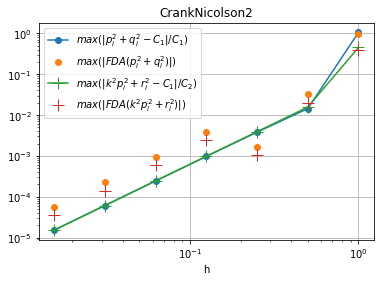

In [13]:
# figure(figsize=(9, 6))
title('CrankNicolson2')
plot(res[:, 0], res[:, 1], marker='o', label=r"$max(\left|p_i^2  + q_i^2 - C_1\right|/C_1)$")
plot(res[:, 0], res[:, 2], 'o', label=r"$max(\left|FDA(p_i^2  + q_i^2)\right|)$")
plot(res[:, 0], res[:, 3], marker='+', markersize=12, label=r"$max(\left|k^2p_i^2  + r_i^2 - C_1\right|/C_2)$")
plot(res[:, 0], res[:, 4], '+', markersize=12, label=r"$max(\left|FDA(k^2p_i^2  + r_i^2)\right|)$")
grid()
yscale("log")
xscale("log")
legend(loc='best', fancybox=True)
xlabel('h')
# ylabel('u')
show() if isShow else savefig('figRKFDA5.pdf')
close()

In [14]:
xk, n = 1000., 7
EPS = array([1.e+1/2**n for n in range(9)], dtype=float64)
H =  array([5.0e-1/2**i for i in range(5)], dtype=float64)
hM, epsM = meshgrid(H, EPS, indexing='ij')
R0 = empty_like(epsM)
R1 = empty_like(epsM)

# print(" "*10, "&", " & ".join(["\multicolumn{2}{c|}{" + f"h = {h:<6}" + "}" for h in H]), r"\\ \hline")
for n in range(len(EPS)):
    eps = EPS[n]
    r = [f"{eps:<10}"]
    for i in range(len(H)):
        h = H[i]
        y = empty(2, dtype=float64)
        x, y[:], r0, r1 = 0., (0., 1.), 0., 0.
        while x < xk:
            x += h
            y = y + h*RK4(Duffing, [eps], y, h)
            r0 = max(r0, abs(y[1]**2/2 + y[0]**2/2 + eps*y[0]**4/4 - 0.5))
            r1 = max(r1, h**4*abs(-eps**3*y[0]**7*y[1]/16 -\
    eps**2*y[0]**3*y[1]*(3*y[0]**2 - 5*y[1]**2)/24 - eps*y[0]*y[1]*(3*y[0]**2 - 4*y[1]**2)/48))
        R0[i, n] = r0
        R1[i, n] = r1
        r.append(f"{r0:<10.1e}")
#         r.append(f"{r1:<10.2e}")
        r.append(f"{h**5*eps**3:<10.1e}")
#     print(" & ".join(r), r"\\ \hline")

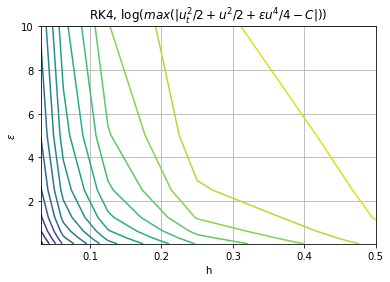

In [15]:
title(r'RK4, $\log(max(\left|u_t^2/2 + u^2/2 + \varepsilon u^4/4 - C\right|))$')
contour(hM, epsM, log(R0), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA6.pdf')
close()

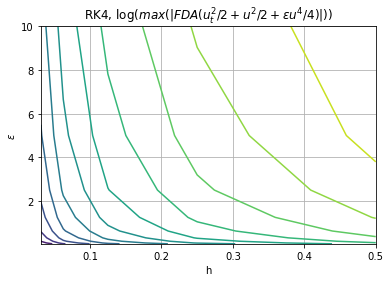

In [16]:
title(r'RK4, $\log(max(\left|FDA(u_t^2/2 + u^2/2 + \varepsilon u^4/4)\right|))$')
contour(hM, epsM, log(R1), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA7.pdf')
close()

In [17]:
xk, n = 1000., 7
EPS = array([1.e+1/2**n for n in range(12)], dtype=float64)
H =  array([5.0e-1/2**i for i in range(5)], dtype=float64)
hM, epsM = meshgrid(H, EPS, indexing='ij')
R0 = empty_like(epsM)
R1 = empty_like(epsM)

# print(" "*10, "&", " & ".join(["\multicolumn{2}{c|}{" + f"h = {h:<6}" + "}" for h in H]), r"\\ \hline")
for n in range(len(EPS)):
    eps = EPS[n]
    r = [f"{eps:<10}"]
    for i in range(len(H)):
        h = H[i]
        y = empty(2, dtype=float64)
        x, y[:], r0, r1 = 0., (0., 1.), 0., 0.
        while x < xk:
            x += h
            y = y + h*DormandPrince5(Duffing, [eps], y, h)
            r0 = max(r0, abs(y[1]**2/2 + y[0]**2/2 + eps*y[0]**4/4 - 0.5))
            r1 = max(r1, h**5*abs(-19*eps**4*y[0]**10/7200 + eps**3*(-17*y[0]**8/2400 -\
    y[0]**6*y[1]**2/480) - 47*eps**2*y[0]**6/7200 + eps*(-17*y[0]**4/7200 -\
    y[0]**2*y[1]**2/2400) - y[0]**2/3600 - y[1]**2/3600))
        R0[i, n] = r0
        R1[i, n] = r1
        r.append(f"{r0:<10.1e}")
#         r.append(f"{r1:<10.2e}")
        r.append(f"{h**5*eps**3:<10.1e}")
#     print(" & ".join(r), r"\\ \hline")


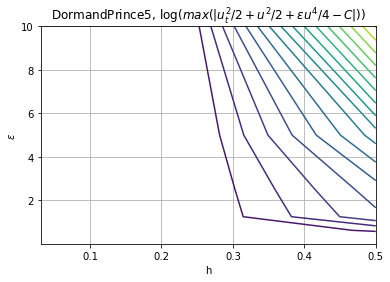

In [18]:
title(r'DormandPrince5, $\log(max(\left|u_t^2/2 + u^2/2 + \varepsilon u^4/4 - C\right|))$')
contour(hM, epsM, (R0), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA8.pdf')
close()

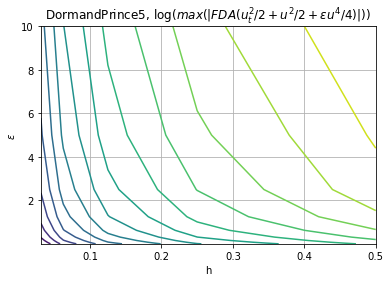

In [19]:
title(r'DormandPrince5, $\log(max(\left|FDA(u_t^2/2 + u^2/2 + \varepsilon u^4/4)\right|))$')
contour(hM, epsM, log(R1), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA9.pdf')
close()

In [20]:
xk, n = 1000., 7
EPS = array([1.e+1/2**n for n in range(9)], dtype=float64)
H =  array([5.0e-1/2**i for i in range(5)], dtype=float64)
hM, epsM = meshgrid(H, EPS, indexing='ij')
R0 = empty_like(epsM)
R1 = empty_like(epsM)

# print(" "*10, "&", " & ".join(["\multicolumn{2}{c|}{" + f"h = {h:<6}" + "}" for h in H]), r"\\ \hline")
for n in range(len(EPS)):
    eps = EPS[n]
    r = [f"{eps:<10}"]
    for i in range(len(H)):
        h = H[i]
        y = empty(2, dtype=float64)
        x, y[:], r0, r1 = 0., (0., 1.), 0., 0.
        while x < xk:
            x += h
            y = y + h*GaussLegendre2(Duffing, [eps], y, h)
            r0 = max(r0, abs(y[1]**2/2 + y[0]**2/2 + eps*y[0]**4/4 - 0.5))
            r1 = max(r1, h**2*abs(eps*y[0]*y[1]**3/4))
        R0[i, n] = r0
        R1[i, n] = r1
        r.append(f"{r0:<10.1e}")
#         r.append(f"{r1:<10.2e}")
        r.append(f"{h**5*eps**3:<10.1e}")
#     print(" & ".join(r), r"\\ \hline")

/tmp/ipykernel_330988/34097067.py:20: RuntimeWarning: overflow encountered in double_scalars
  r1 = max(r1, h**2*abs(eps*y[0]*y[1]**3/4))
/tmp/ipykernel_330988/139919152.py:13: RuntimeWarning: overflow encountered in double_scalars
  -y[0] - eps*y[0]**3,\
/tmp/ipykernel_330988/852424101.py:5: RuntimeWarning: invalid value encountered in add
  y1 = y + h*k1


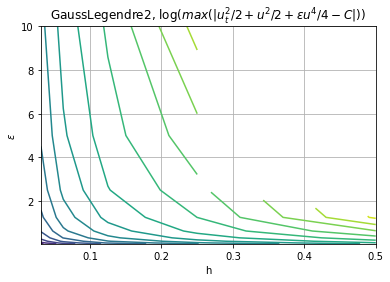

In [21]:
title(r'GaussLegendre2, $\log(max(\left|u_t^2/2 + u^2/2 + \varepsilon u^4/4 - C\right|))$')
contour(hM, epsM, log(R0), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA10.pdf')
close()

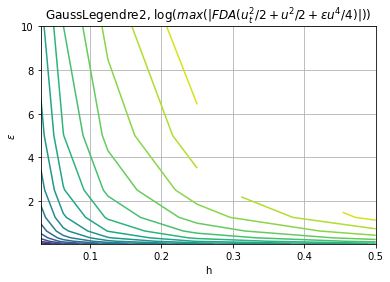

In [22]:
title(r'GaussLegendre2, $\log(max(\left|FDA(u_t^2/2 + u^2/2 + \varepsilon u^4/4)\right|))$')
contour(hM, epsM, log(R1), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA11.pdf')
close()

In [23]:
xk, n = 100., 7
EPS = array([1.e+1/2**n for n in range(9)], dtype=float64)
H =  array([5.0e-1/2**i for i in range(4)], dtype=float64)
hM, epsM = meshgrid(H, EPS, indexing='ij')
R0 = empty_like(epsM)
R1 = empty_like(epsM)

# print(" "*10, "&", " & ".join(["\multicolumn{2}{c|}{" + f"h = {h:<6}" + "}" for h in H]), r"\\ \hline")
for n in range(len(EPS)):
    eps = EPS[n]
    r = [f"{eps:<10}"]
    for i in range(len(H)):
        h = H[i]
        y = empty(2, dtype=float64)
        x, y[:], r0, r1 = 0., (0., 1.), 0., 0.
        while x < xk:
            x += h
            y = y + h*CrankNicolson2(Duffing, [eps], y, h)
            r0 = max(r0, abs(y[1]**2/2 + y[0]**2/2 + eps*y[0]**4/4 - 0.5))
            r1 = max(r1, h**2*abs(eps*y[0]*y[1]**3/4))
        R0[i, n] = r0
        R1[i, n] = r1
        r.append(f"{r0:<10.1e}")
#         r.append(f"{r1:<10.2e}")
        r.append(f"{h**5*eps**3:<10.1e}")
#     print(" & ".join(r), r"\\ \hline")

/tmp/ipykernel_330988/139919152.py:13: RuntimeWarning: overflow encountered in double_scalars
  -y[0] - eps*y[0]**3,\
/tmp/ipykernel_330988/852424101.py:13: RuntimeWarning: invalid value encountered in add
  y1 = y + h*(k1 + k2)/2


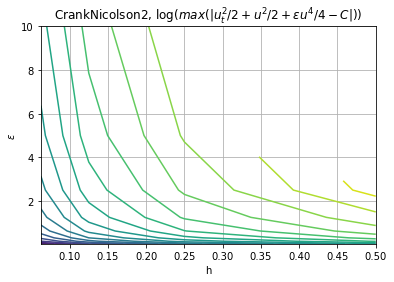

In [24]:
title(r'CrankNicolson2, $\log(max(\left|u_t^2/2 + u^2/2 + \varepsilon u^4/4 - C\right|))$')
contour(hM, epsM, log(R0), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA12.pdf')
close()

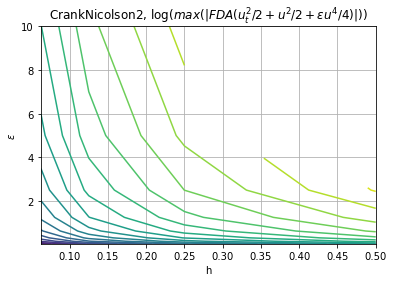

In [25]:
title(r'CrankNicolson2, $\log(max(\left|FDA(u_t^2/2 + u^2/2 + \varepsilon u^4/4)\right|))$')
contour(hM, epsM, log(R1), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA13.pdf')
close()

In [26]:
xk, n = 1., 7
EPS = array([1.e+1/2**n for n in range(6)], dtype=float64)
H =  array([5.0e-1/2**i for i in range(6)], dtype=float64)
hM, epsM = meshgrid(H, EPS, indexing='ij')
R0 = empty_like(epsM)
HEPS0 = hM**4*epsM**5
HEPS1 = hM**4/epsM**5

for n in range(len(EPS)):
    eps = EPS[n]
    for i in range(len(H)):
        h = H[i]
        y = empty(2, dtype=float64)
        x, y[:], r0 = 0., (0., g1(0., eps)), 0.
        while x < xk:
            x += h
            y = y + h*RK4(BoundaryLayer, [eps], y, h)
            r0 = max(r0, abs(y[0] - g(x, eps)))
        R0[n, i] = r0

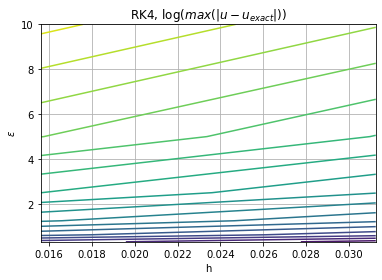

In [27]:
title(r'RK4, $\log(max(\left|u - u_{exact}\right|))$')
contour(hM[4:, :], epsM[4:, :], log(R0[4:, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA14.pdf')
close()

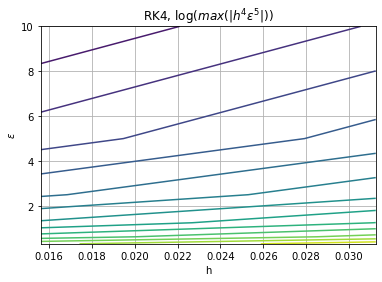

In [28]:
title(r'RK4, $\log(max(\left|h^4 \varepsilon^5\right|))$')
contour(hM[4:, :], epsM[4:, :], log(HEPS1[4:, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA15.pdf')
close()

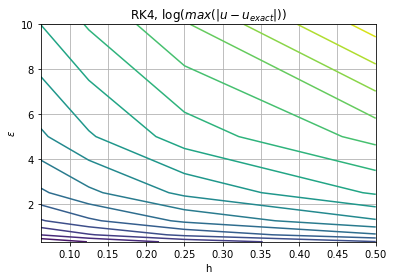

In [29]:
title(r'RK4, $\log(max(\left|u - u_{exact}\right|))$')
contour(hM[:4, :], epsM[:4, :], log(R0[:4, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA16.pdf')
close()

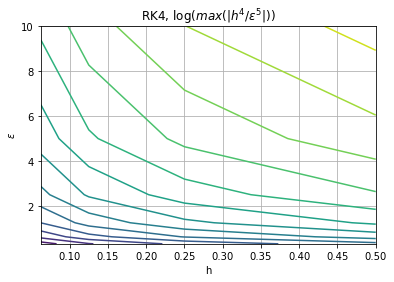

In [30]:
title(r'RK4, $\log(max(\left|h^4 / \varepsilon^5\right|))$')
contour(hM[:4, :], epsM[:4, :], log(HEPS0[:4, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA17.pdf')
close()

In [31]:
xk, n = 1., 7
EPS = array([1.e+1/2**n for n in range(6)], dtype=float64)
H =  array([5.0e-1/2**i for i in range(6)], dtype=float64)
hM, epsM = meshgrid(H, EPS, indexing='ij')
R0 = empty_like(epsM)
HEPS0 = hM**4*epsM**5
HEPS1 = hM**4/epsM**5

for n in range(len(EPS)):
    eps = EPS[n]
    for i in range(len(H)):
        h = H[i]
        y = empty(2, dtype=float64)
        x, y[:], r0 = 0., (0., g1(0., eps)), 0.
        while x < xk:
            x += h
            y = y + h*DormandPrince5(BoundaryLayer, [eps], y, h)
            r0 = max(r0, abs(y[0] - g(x, eps)))
        R0[n, i] = r0

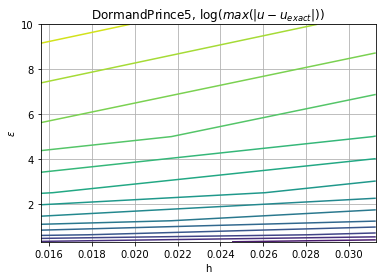

In [32]:
title(r'DormandPrince5, $\log(max(\left|u - u_{exact}\right|))$')
contour(hM[4:, :], epsM[4:, :], log(R0[4:, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA18.pdf')
close()

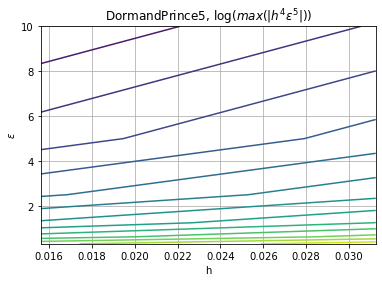

In [33]:
title(r'DormandPrince5, $\log(max(\left|h^4 \varepsilon^5\right|))$')
contour(hM[4:, :], epsM[4:, :], log(HEPS1[4:, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA19.pdf')
close()

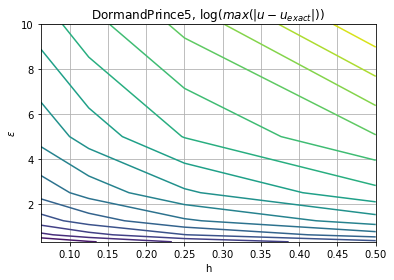

In [34]:
title(r'DormandPrince5, $\log(max(\left|u - u_{exact}\right|))$')
contour(hM[:4, :], epsM[:4, :], log(R0[:4, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA20.pdf')
close()

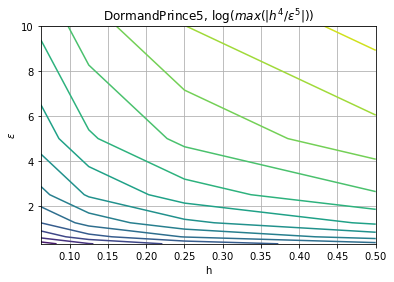

In [35]:
title(r'DormandPrince5, $\log(max(\left|h^4 / \varepsilon^5\right|))$')
contour(hM[:4, :], epsM[:4, :], log(HEPS0[:4, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA21.pdf')
close()

In [36]:
xk, n = 1., 7
EPS = array([1.e+1/2**n for n in range(6)], dtype=float64)
H =  array([5.0e-1/2**i for i in range(6)], dtype=float64)
hM, epsM = meshgrid(H, EPS, indexing='ij')
R0 = empty_like(epsM)
HEPS0 = hM**4*epsM**5
HEPS1 = hM**4/epsM**5

for n in range(len(EPS)):
    eps = EPS[n]
    for i in range(len(H)):
        h = H[i]
        y = empty(2, dtype=float64)
        x, y[:], r0 = 0., (0., g1(0., eps)), 0.
        while x < xk:
            x += h
            y = y + h*GaussLegendre2(BoundaryLayer, [eps], y, h)
            r0 = max(r0, abs(y[0] - g(x, eps)))
        R0[n, i] = r0

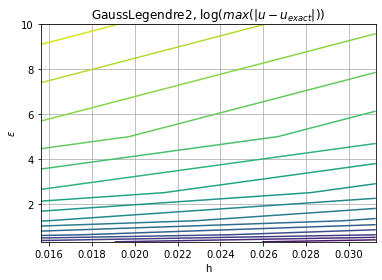

In [37]:
title(r'GaussLegendre2, $\log(max(\left|u - u_{exact}\right|))$')
contour(hM[4:, :], epsM[4:, :], log(R0[4:, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA22.pdf')
close()

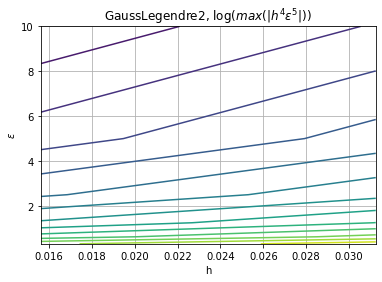

In [38]:
title(r'GaussLegendre2, $\log(max(\left|h^4 \varepsilon^5\right|))$')
contour(hM[4:, :], epsM[4:, :], log(HEPS1[4:, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA23.pdf')
close()

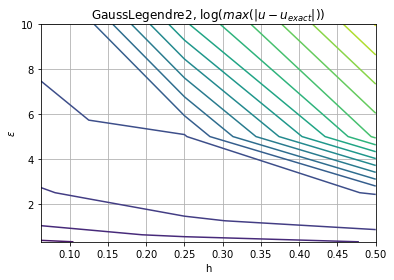

In [39]:
title(r'GaussLegendre2, $\log(max(\left|u - u_{exact}\right|))$')
contour(hM[:4, :], epsM[:4, :], log(R0[:4, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA24.pdf')
close()

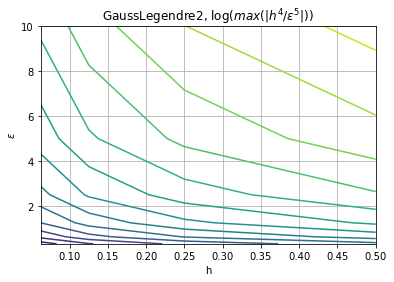

In [40]:
title(r'GaussLegendre2, $\log(max(\left|h^4 / \varepsilon^5\right|))$')
contour(hM[:4, :], epsM[:4, :], log(HEPS0[:4, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA25.pdf')
close()

In [41]:
xk, n = 1., 7
EPS = array([1.e+1/2**n for n in range(6)], dtype=float64)
H =  array([5.0e-1/2**i for i in range(6)], dtype=float64)
hM, epsM = meshgrid(H, EPS, indexing='ij')
R0 = empty_like(epsM)
HEPS0 = hM**4*epsM**5
HEPS1 = hM**4/epsM**5

for n in range(len(EPS)):
    eps = EPS[n]
    for i in range(len(H)):
        h = H[i]
        y = empty(2, dtype=float64)
        x, y[:], r0 = 0., (0., g1(0., eps)), 0.
        while x < xk:
            x += h
            y = y + h*CrankNicolson2(BoundaryLayer, [eps], y, h)
            r0 = max(r0, abs(y[0] - g(x, eps)))
        R0[n, i] = r0

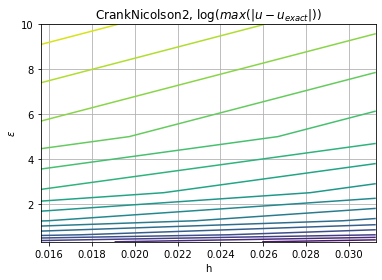

In [42]:
title(r'CrankNicolson2, $\log(max(\left|u - u_{exact}\right|))$')
contour(hM[4:, :], epsM[4:, :], log(R0[4:, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA26.pdf')
close()

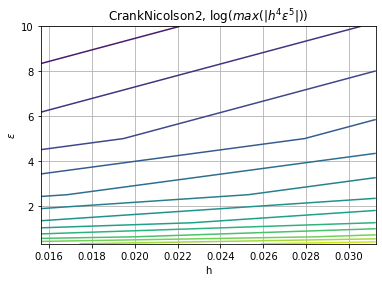

In [43]:
title(r'CrankNicolson2, $\log(max(\left|h^4 \varepsilon^5\right|))$')
contour(hM[4:, :], epsM[4:, :], log(HEPS1[4:, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA27.pdf')
close()

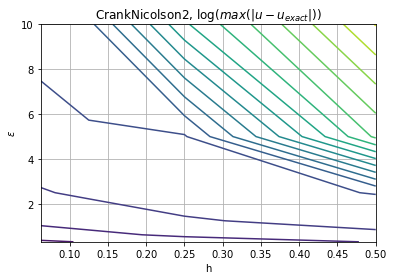

In [44]:
title(r'CrankNicolson2, $\log(max(\left|u - u_{exact}\right|))$')
contour(hM[:4, :], epsM[:4, :], log(R0[:4, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA28.pdf')
close()

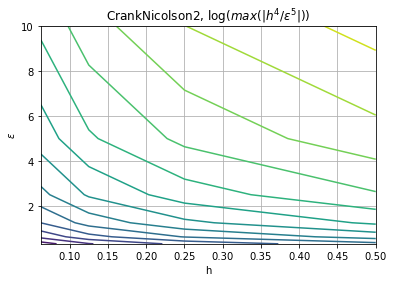

In [45]:
title(r'CrankNicolson2, $\log(max(\left|h^4 / \varepsilon^5\right|))$')
contour(hM[:4, :], epsM[:4, :], log(HEPS0[:4, :]), levels = 16)
grid()
# yscale("log")
# xscale("log")
xlabel('h')
ylabel(r'$\varepsilon$')
show() if isShow else savefig('figRKFDA29.pdf')
close()